# Temporal-Difference Methods

In this notebook, you will write your own implementations of many Temporal-Difference (TD) methods.

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

---

### Part 0: Explore CliffWalkingEnv

We begin by importing the necessary packages.

In [32]:
import sys
import gym
import numpy as np
from collections import defaultdict, deque
import matplotlib.pyplot as plt
%matplotlib inline

import check_test
from plot_utils import plot_values

Use the code cell below to create an instance of the [CliffWalking](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py) environment.

In [33]:
env = gym.make('CliffWalking-v0')

/Users/Tristan/anaconda3/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


The agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through `46`.

The agent has 4 potential actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.  Verify this by running the code cell below.

In [34]:
print(env.action_space)
print(env.observation_space)

Discrete(4)
Discrete(48)


In this mini-project, we will build towards finding the optimal policy for the CliffWalking environment.  The optimal state-value function is visualized below.  Please take the time now to make sure that you understand _why_ this is the optimal state-value function.

_**Note**: You can safely ignore the values of the cliff "states" as these are not true states from which the agent can make decisions.  For the cliff "states", the state-value function is not well-defined._

/Users/Tristan/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/Tristan/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/Tristan/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/Tristan/anaconda3/lib/python3.7/site-packages/matplotlib/cbo

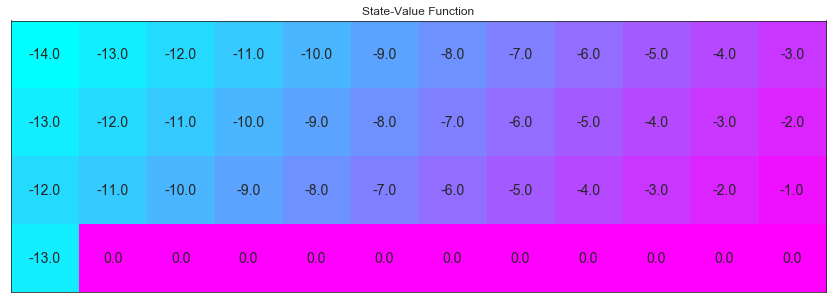

In [35]:
# define the optimal state-value function
V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)

### Part 1: TD Control: Sarsa

In this section, you will write your own implementation of the Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [36]:
def update_Q_sarsa(Q, state, action, reward, alpha, gamma, next_state=None, next_action=None):
    Qsa_current = Q[state][action]
    Qsa_next = Q[next_state][next_action] if next_state is not None else 0
    target = reward + gamma*Qsa_next
    Q_updated = Qsa_current + alpha*(target - Qsa_current)
    return Q_updated
    
def eps_greedy(Q, state, nA, eps):
    if np.random.random() > eps:
        # Choose greedy argmax
        action = np.argmax(Q[state])
    else:
        # Choose equirandom state from A action space
        action = np.random.choice(np.arange(env.action_space.n))
    return action

In [39]:
def sarsa(env, num_episodes, alpha, gamma=1.0, eps_start=0.2, eps_decay=0.9999, eps_min=0.01, plot_every=100):
    # initialize action-value function (empty dictionary of arrays)
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(env.nA))
    # initialize performance monitor
    tmp_scores = deque(maxlen=plot_every)     # deque for keeping track of scores
    avg_scores = deque(maxlen=num_episodes)   # average scores over every plot_every episodes
    
    # loop over episodes
    eps = eps_start
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
        
        ## TODO: complete the function
        score = 0
        state = env.reset()
        #eps = max(eps*eps_decay, eps_min)
        eps = 1.0/i_episode
        action = eps_greedy(Q, state, nA, eps)
        
        # Run one step ahead (not full ep)
        while True:
            # Take action A_t and observe R_{t+1}, S_{t+1}
            next_state, reward, done, info = env.step(action)
            score += reward 
            if not done:
                # Choose action A_{t+1} using e-greedy policy derived from Q
                next_action = eps_greedy(Q, next_state, nA, eps)
                # Update the Q table for Q(S_t,A_t) using Q(S_{t+1},A_{t+1})
                Q[state][action] = update_Q_sarsa(Q, state, action, reward, alpha, gamma, next_state, next_action)
                
                state = next_state # s -> s'
                action = next_action # a -> a'
            if done:
                Q[state][action] = update_Q_sarsa(Q, state, action, reward, alpha, gamma)
                tmp_scores.append(score)    # append score
                break 
        if (i_episode % plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))
    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(avg_scores),endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))     
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000

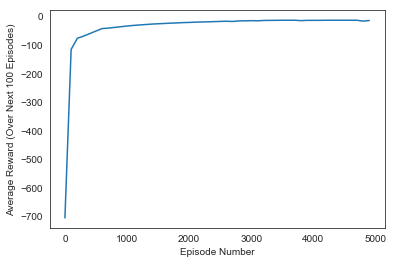

Best Average Reward over 100 Episodes:  -13.0


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 2  1  1  1  0  2  1  1  1  1  1  2]
 [ 1  3  1  3  2  1  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


/Users/Tristan/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/Tristan/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/Tristan/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/Tristan/anaconda3/lib/python3.7/site-packages/matplotlib/cbo

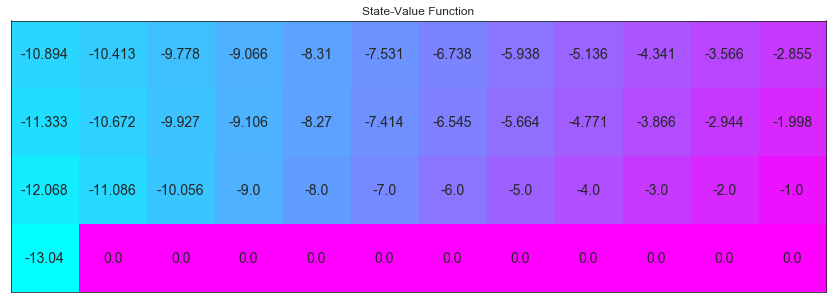

In [41]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsa = sarsa(env, 5000, .01)

# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_sarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)

##### Mistakes made
* Forgot to make next_state, next_action = None on the last state of an episode
* Passed state S_t not S_{t+1} into epsilon-greedy to get the next next action - remember we evaluate a further step ahead and already have A_t from env.step(state) but need A_{t+1} which comes from S_{t+1}

In [42]:
def update_Q_sarsamax(alpha, gamma, Q, state, action, reward, next_state=None):
    Qsa_current = Q[state][action]
    Qsa_next = np.max(Q[next_state]) if next_state is not None else 0
    target = reward + gamma*Qsa_next
    Q_updated = Qsa_current + alpha*(target - Qsa_current)
    return Q_updated

In [43]:
def q_learning(env, num_episodes, alpha, gamma=1.0, plot_every=100):
    """Q-Learning - TD Control
    
    Params
    ======
        num_episodes (int): number of episodes to run the algorithm
        alpha (float): learning rate
        gamma (float): discount factor
        plot_every (int): number of episodes to use when calculating average score
    """
    nA = env.action_space.n                # number of actions
    Q = defaultdict(lambda: np.zeros(nA))  # initialize empty dictionary of arrays
    
    # monitor performance
    tmp_scores = deque(maxlen=plot_every)     # deque for keeping track of scores
    avg_scores = deque(maxlen=num_episodes)   # average scores over every plot_every episodes
    
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        score = 0                                              # initialize score
        state = env.reset()                                    # start episode
        eps = 1.0 / i_episode                                  # set value of epsilon
        
        while True:
            action = eps_greedy(Q, state, nA, eps)         # epsilon-greedy action selection
            next_state, reward, done, info = env.step(action)  # take action A, observe R, S'
            score += reward                                    # add reward to agent's score
            Q[state][action] = update_Q_sarsamax(alpha, gamma, Q, \
                                                 state, action, reward, next_state)        
            state = next_state                                 # S <- S'
            if done:
                tmp_scores.append(score)                       # append score
                break
        if (i_episode % plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))
            
    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(avg_scores),endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function. 

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000

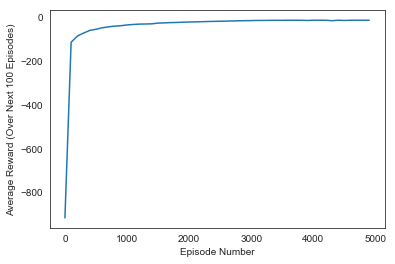

Best Average Reward over 100 Episodes:  -13.0


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 3  0  0  0  2  2  2  0  2  1  1  2]
 [ 2  3  2  1  1  1  2  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


/Users/Tristan/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/Tristan/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/Tristan/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/Tristan/anaconda3/lib/python3.7/site-packages/matplotlib/cbo

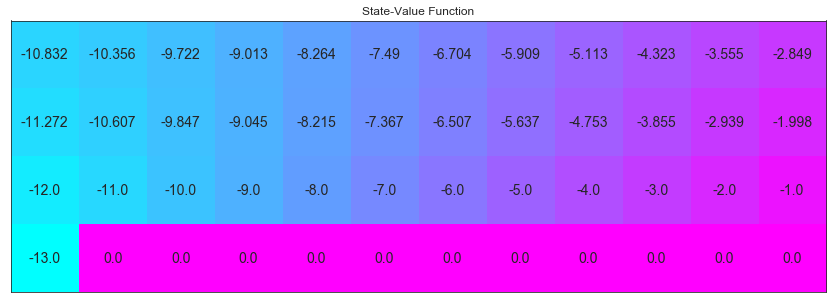

In [45]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsamax = q_learning(env, 5000, .01)

# print the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
check_test.run_check('td_control_check', policy_sarsamax)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

# plot the estimated optimal state-value function
plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])

### Part 3: TD Control: Expected Sarsa

In this section, you will write your own implementation of the Expected Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [91]:
 def update_Q_expectedsarsa(alpha, gamma, Q, state, action, reward, eps, nA, next_state=None):
    Qsa_current = Q[state][action]
    policy_s = np.ones(nA) * eps / nA
    policy_s[np.argmax(Q[next_state])] += 1 - eps 
    # Now compute expectation over all actions for S_{t+1}
    Qsa_next = np.dot(policy_s, Q[next_state]) # if next_state is not None else 0
    target = reward + gamma* Qsa_next
    Q_updated = Qsa_current + alpha*(target - Qsa_current)
    return Q_updated

In [133]:
def expected_sarsa(env, num_episodes, alpha, gamma=1.0, plot_every=100, eps_decay=0.9999, eps_min=0, eps_start=0.0001):
    nA = env.action_space.n                # number of actions
    Q = defaultdict(lambda: np.zeros(nA))  # initialize empty dictionary of arrays
    
    # monitor performance
    tmp_scores = deque(maxlen=plot_every)     # deque for keeping track of scores
    avg_scores = deque(maxlen=num_episodes)   # average scores over every plot_every episodes
    
    eps = eps_start
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        score = 0                                              # initialize score
        state = env.reset()                                    # start episode
        #eps = 1.0 / i_episode                                  # set value of epsilon
        #eps = 0.005
        eps = max(eps_min, eps*eps_decay)
        while True:
            action = eps_greedy(Q, state, nA, eps)         # epsilon-greedy action selection
            next_state, reward, done, info = env.step(action)  # take action A, observe R, S'
            score += reward                                    # add reward to agent's score
            Q[state][action] = update_Q_expectedsarsa(alpha, gamma, Q, \
                                                 state, action, reward, eps, nA, next_state)        
            state = next_state                                 # S <- S'
            if done:
                tmp_scores.append(score)                       # append score
                break
        if (i_episode % plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))
            
    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(avg_scores),endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000

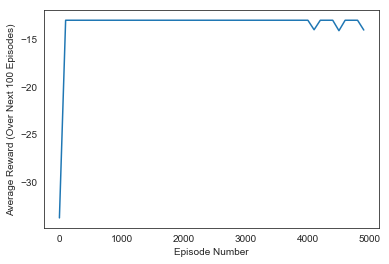

Best Average Reward over 100 Episodes:  -13.0


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  1  1  1  1  1  1  3  0  1  1  2]
 [ 2  1  1  1  0  1  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


/Users/Tristan/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/Tristan/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/Tristan/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/Tristan/anaconda3/lib/python3.7/site-packages/matplotlib/cbo

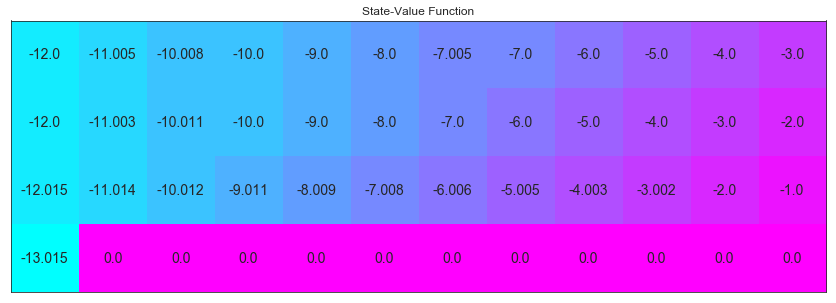

In [134]:
# obtain the estimated optimal policy and corresponding action-value function
Q_expsarsa = expected_sarsa(env, 5000, 1)

# print the estimated optimal policy
policy_expsarsa = np.array([np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_expsarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)

# plot the estimated optimal state-value function
plot_values([np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)])

In [147]:
[(key,Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)]

[(0, array([-13.00005037, -12.00020043, -13.00025226, -12.00069978])),
 (1, array([-12.00020043, -11.00529584, -12.0007253 , -13.00005037])),
 (2, array([-11.00012531, -10.0082433 , -11.00534561, -11.00017536])),
 (3, array([-10.00022535, -10.00007647, -10.01255754, -11.00005048])),
 (4, array([-10.00007647,  -9.00017548,  -9.01260713,  -9.01004206])),
 (5, array([-9.00007598, -8.00037577, -8.00559677, -9.00759361])),
 (6, array([-8.0001253 , -7.00532124, -8.0002256 , -8.00547209])),
 (7, array([-7.00014999, -7.00007491, -7.00017555, -7.00005014])),
 (8, array([-6.00004999, -6.00007492, -6.00015026, -7.00007508])),
 (9, array([-5.00007502, -5.00007488, -5.00010022, -5.00010001])),
 (10, array([-4.00004997, -4.00004991, -4.00005009, -5.00007502])),
 (11, array([-4.000025  , -3.00012496, -3.00002495, -3.00010004])),
 (12, array([-12.00811701, -12.00247229, -12.00035334, -12.00064995])),
 (13, array([-12.00015026, -11.00317519, -12.01434079, -12.00020026])),
 (14, array([-11.005746  , -10

In [143]:
[(key,np.max(Q_expsarsa[key]),np.argmax(Q_expsarsa[key])) if key in Q_expsarsa else -1 for key in np.arange(48)]

[(0, -12.000200433691425, 1),
 (1, -11.005295835899124, 1),
 (2, -10.00824330142941, 1),
 (3, -10.00007647278509, 1),
 (4, -9.0001754763804, 1),
 (5, -8.000375769237476, 1),
 (6, -7.005321236482973, 1),
 (7, -7.000050137951385, 3),
 (8, -6.000049988142414, 0),
 (9, -5.000074875117355, 1),
 (10, -4.000049909458646, 1),
 (11, -3.0000249475507514, 2),
 (12, -12.000353343127463, 2),
 (13, -11.003175192524289, 1),
 (14, -10.010666152006525, 1),
 (15, -10.000076400527492, 1),
 (16, -9.000075912034374, 0),
 (17, -8.000150575652182, 1),
 (18, -7.0001754573052475, 1),
 (19, -6.000150113656005, 1),
 (20, -5.000100049227227, 1),
 (21, -4.0000499978420585, 1),
 (22, -3.0000249350790975, 1),
 (23, -2.000000003738439, 2),
 (24, -12.015169581664162, 1),
 (25, -11.013758519627698, 1),
 (26, -10.012149950389846, 1),
 (27, -9.010708632591028, 1),
 (28, -8.009221979941966, 1),
 (29, -7.007735399474153, 1),
 (30, -6.006233735653203, 1),
 (31, -5.0047016027557305, 1),
 (32, -4.003184829292076, 1),
 (33, -3